#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 890kB 33.5MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=98ff750814e6a4a597e674c3b4678124c5a8665c64ef6806bf72d97477f0642c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 9.2MB/s 
     |████████████████████████████████| 163kB 8.4MB/s 
     |████████████████████████████████| 245kB 8.9MB/s 
     |████████████████████████████████| 17.7MB 219kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [5]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
MODEL = 'bart'
MODELS = {}

In [7]:
# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_para/bart/'

    OUTPUT_PATH = drive_dir+'summarization/assign_bullets_para/bart/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_para/pegasus/'

    OUTPUT_PATH = drive_dir+'summarization/assign_bullets_para/pegasus/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

### **Init**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [9]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [10]:
def print_example(idx, text, summ, summ_num_tok, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction (%d tokens):'%summ_num_tok)
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [11]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, summ_num_tok, row.bullets)

##### Plot Evaluation

In [12]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))

    fig, ax = plt.subplots(figsize=(10, 6))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for r in prf],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for rouge, var in zip(config.ROUGE_TYPES,
            np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Assign Bullets Para**

In [13]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [14]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model




BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-12-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1"

In [15]:
print_examples(drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_train)

[*] importing the model

BartConfig {
  "_name_or_path": "/content/drive/My Drive/MAGMA: Summarization/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_

##### Print Val Examples

In [16]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of low back pain syndromes. The most common causes of
low back pain are mechanical in origin. Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal structure.
The most important traumatic factors in low back pain relate to soft tissue structures. Precise identification of the injured tissue, and the role of
that injury in the consequent pain and dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet joints,
ligaments or spinal nerves. Aging causes modification of these structures over time, and different parts of the spine tend to be at greater risk for
change or injury during different decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the sixth decade of
life (Table 3.1).

Prediction (46 tokens):
 M

In [17]:
print_examples(drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_val)

[+] model already present in cache

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of low back pain syndromes. The most common causes of
low back pain are mechanical in origin. Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal structure.
The most important traumatic factors in low back pain relate to soft tissue structures. Precise identification of the injured tissue, and the role of
that injury in the consequent pain and dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet joints,
ligaments or spinal nerves. Aging causes modification of these structures over time, and different parts of the spine tend to be at greater risk for
change or injury during different decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the sixth decade of
life (Table 3.1).

Prediction (39 tokens):
Th

##### Print Test Examples

In [18]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep brain stimulator - have received licenses for the
adjunctive treatment of refractory epilepsy, the last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely available for partial seizures. Rufinamide (RFN) has been
licensed in Europe and the USA for adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is licensed in Europe as
adjunctive treatment for partial seizures with or without secondary generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have
recently been approved for use in Europe and the USA for the same indication. After 20 years of global experience, vigabatrin (VGB) has been approved
in the USA for the treatment of infantile spasms a

In [19]:
print_examples(drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_test)

[+] model already present in cache

(9781908541277, 'ch_8')
After a hiatus of nearly 20 years, 16 new AEDs and two devices - the vagus nerve stimulator and deep brain stimulator - have received licenses for the
adjunctive treatment of refractory epilepsy, the last so far only in Europe. Gabapentin (GBP), lacosamide (LCM), LTG, levetiracetam (LEV),
oxcarbazepine (OXC), pregabalin (PGB), tiagabine (TGB), TPM and zonisamide (ZNS) are widely available for partial seizures. Rufinamide (RFN) has been
licensed in Europe and the USA for adjunctive treatment of seizures in Lennox-Gastaut syndrome. Eslicarbazepine acetate (ESL) is licensed in Europe as
adjunctive treatment for partial seizures with or without secondary generalization. Retigabine (RTG; ezogabine in the USA) and perampanel (PER) have
recently been approved for use in Europe and the USA for the same indication. After 20 years of global experience, vigabatrin (VGB) has been approved
in the USA for the treatment of infantile spasms a

##### Summarize Test

In [20]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [21]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


In [22]:
df_test = summarize(drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train', df_test, 10)

[+] model already present in cache

100%|██████████| 25/25 [01:14<00:00,  2.96s/it]


### **Evaluation**

In [24]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [25]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [26]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

In [27]:
df_test = evaluate_model(df_test, drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train')

##### Plot Evaluation

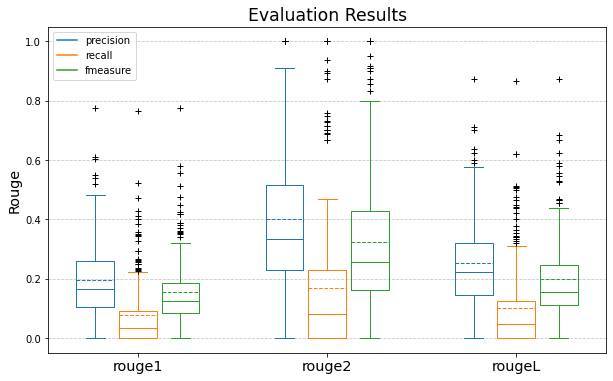

In [29]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')

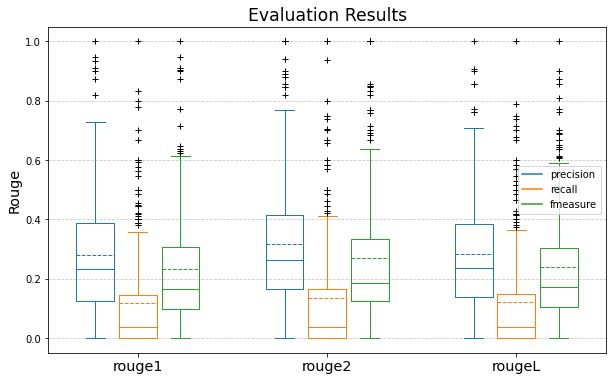

In [30]:
plot_evaluation(drive_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_train')